# Create Spark Sesssion

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import findspark
from pyspark.sql.types import StructType, StructField, LongType, StringType
import pandas as pd

In [2]:
## DEFINE SENSITIVE VARIABLES
MINIO_ACCESS_KEY = "Access-key"
MINIO_SECRET_KEY = "Private-key"

In [3]:
# Create a list of JAR files
jar_files = [
    "jars/iceberg-spark-runtime-3.5_2.12-1.5.2.jar",
    "jars/nessie-spark-extensions-3.5_2.12-0.94.1.jar",
    "jars/bundle-2.17.178.jar",
    "jars/url-connection-client-2.17.178.jar",
    "jars/hadoop-common-3.3.6.jar",
    "jars/hadoop-aws-3.3.6.jar",
    "jars/hadoop-client-3.3.6.jar",
    "jars/aws-java-sdk-bundle-1.12.765.jar"
]

In [4]:
import os
# Check if each file in jar_files exists
for jar in jar_files:
    if not os.path.isfile(jar):
        print(f"File does not exist: {jar}")

In [5]:
conf = SparkConf() \
        .setAppName("apsadfs") \
    	.set("spark.master", "spark://spark-master:7077") \
        .set("spark.jars", ",".join(jar_files)) \
        .set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
        .set("spark.sql.catalog.nessie", "org.apache.iceberg.spark.SparkCatalog") \
        .set("spark.sql.catalog.nessie.warehouse", "s3a://spark") \
        .set("spark.sql.catalog.nessie.s3.endpoint", "http://nginx:9000") \
        .set("spark.sql.catalog.nessie.catalog-impl", "org.apache.iceberg.nessie.NessieCatalog") \
        .set("spark.sql.catalog.nessie.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
        .set("spark.sql.catalog.nessie.uri", "http://nessie:19120/api/v2") \
        .set("spark.sql.catalog.nessie.ref", "main") \
        .set("spark.sql.catalog.nessie.cache-enabled", "false") \
        .set("spark.sql.catalog.nessie.authentication.type", "NONE") \
        .set("spark.hadoop.fs.s3a.endpoint", "http://nginx:9000") \
        .set('spark.hadoop.fs.s3a.access.key', MINIO_ACCESS_KEY) \
        .set('spark.hadoop.fs.s3a.secret.key', MINIO_SECRET_KEY) \
        .set('spark.hadoop.fs.s3a.path.style.access', "true") \
        .set('spark.hadoop.fs.s3a.connection.ssl.enabled', "false") \
        .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')

## Start Spark Session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Running")

Spark Running


# Preprocess

## Iceberg error

In [6]:
spark.sql("SHOW DATABASES").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [11]:
spark.sql("SELECT*FROM nessie.db.order_details")

DataFrame[order_id: bigint, row_id: bigint, order_priority: string, discount: decimal(10,2), unit_price: decimal(10,2), shipping_cost: decimal(10,2), ship_mode: string, ship_date: string, product_name: string, profit: decimal(10,2), quantity_ordered_new: bigint, sales: decimal(10,2)]

In [12]:
test = spark.read.format("iceberg").load("nessie.db.order_details")
test.show(5)

+--------+------+--------------+--------+----------+-------------+---------+---------+------------+------+--------------------+-----+
|order_id|row_id|order_priority|discount|unit_price|shipping_cost|ship_mode|ship_date|product_name|profit|quantity_ordered_new|sales|
+--------+------+--------------+--------+----------+-------------+---------+---------+------------+------+--------------------+-----+
+--------+------+--------------+--------+----------+-------------+---------+---------+------------+------+--------------------+-----+



## Customer table

In [126]:
customer_file = 's3a://spark/raw/customer.parquet'
customer_df = spark.read.parquet(customer_file, header=True, inferSchema=True)

In [127]:
# Kiểm tra schema
customer_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- state_or_province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: long (nullable = true)



In [128]:
nullable_false = [StructField(field.name, field.dataType, False) for field in customer_df.schema.fields]

new_schema = StructType(nullable_false)

customer = spark.createDataFrame(customer_df.rdd, new_schema)

customer.printSchema()

customer.show(10)

root
 |-- id: long (nullable = false)
 |-- name: string (nullable = false)
 |-- segment: string (nullable = false)
 |-- country: string (nullable = false)
 |-- region: string (nullable = false)
 |-- state_or_province: string (nullable = false)
 |-- city: string (nullable = false)
 |-- postal_code: long (nullable = false)

+----+--------------------+--------------+-------------+-------+-----------------+-------------+-----------+
|  id|                name|       segment|      country| region|state_or_province|         city|postal_code|
+----+--------------------+--------------+-------------+-------+-----------------+-------------+-----------+
| 553|   Kristine Connolly|     Corporate|United States|   West|       California|  Los Angeles|      90008|
|3106|   Alexander O'Brien|   Home Office|United States|Central|            Texas|      Houston|      77041|
|1106|Maxine Collier Grady|Small Business|United States|Central|            Texas|       Dallas|      75220|
|2382|   Geoffrey Saun

In [129]:
drop_column = ['country', 'postal_code']
customer_filter = customer_df.drop(*drop_column).show(10)

+----+--------------------+--------------+-------+-----------------+-------------+
|  id|                name|       segment| region|state_or_province|         city|
+----+--------------------+--------------+-------+-----------------+-------------+
| 553|   Kristine Connolly|     Corporate|   West|       California|  Los Angeles|
|3106|   Alexander O'Brien|   Home Office|Central|            Texas|      Houston|
|1106|Maxine Collier Grady|Small Business|Central|            Texas|       Dallas|
|2382|   Geoffrey Saunders|Small Business|   East|         New York|New York City|
| 553|   Kristine Connolly|     Corporate|   West|       California|  Los Angeles|
| 699|          Jenny Gold|      Consumer|   West|       California|  Los Angeles|
| 471|        Ross Simpson|      Consumer|  South|          Georgia|      Atlanta|
| 342|    Jacqueline Noble|     Corporate|  South|          Florida|        Miami|
| 102|   Caroline Johnston|      Consumer|   East|    Massachusetts|       Boston|
| 18

In [130]:
# Đăng ký DataFrame dưới dạng một bảng tạm thời
customer.createOrReplaceTempView("customer_table")

spark.sql("CREATE TABLE IF NOT EXISTS nessie.customers USING iceberg PARTITIONED BY (state_or_province) AS SELECT * FROM customer_table ORDER BY state_or_province;")

DataFrame[]

In [131]:
test = spark.read.format("iceberg").load("nessie.customers")
test.show(5)

+----+--------------+--------------+-------------+------+-----------------+--------------+-----------+
|  id|          name|       segment|      country|region|state_or_province|          city|postal_code|
+----+--------------+--------------+-------------+------+-----------------+--------------+-----------+
|2847|   Vanessa Day|     Corporate|United States| South|        Tennessee|  Collierville|      38017|
|2848| Eileen Dalton|     Corporate|United States| South|        Tennessee|      Columbia|      38401|
|3225|Robyn Crawford|Small Business|United States| South|        Tennessee|    Germantown|      38138|
|3224| Claudia White|Small Business|United States| South|        Tennessee|      Gallatin|      37066|
|3226|   Arthur Gold|Small Business|United States| South|        Tennessee|Hendersonville|      37075|
+----+--------------+--------------+-------------+------+-----------------+--------------+-----------+
only showing top 5 rows



## Order table

In [132]:
order0_file = 's3a://spark/raw/order0.parquet'
order1_file = 's3a://spark/raw/order1.parquet'
order2_file = 's3a://spark/raw/order2.parquet'

In [133]:
# Định nghĩa schema mới
order_schema = StructType([
    StructField("id", LongType(), nullable=False),
    StructField("order_date", StringType(), nullable=False),
    StructField("customer_id", LongType(), nullable=False),
])

In [134]:
order0_df_raw = spark.read.parquet(order0_file, header=True)
order1_df_raw = spark.read.parquet(order1_file, header=True)
order2_df_raw = spark.read.parquet(order2_file, header=True)

print(order0_df_raw.count())
print(order1_df_raw.count())
print(order2_df_raw.count())

437
446
482


In [135]:
order_combined=order0_df_raw.union(order1_df_raw).union(order2_df_raw)
print(order_combined.count())

1365


In [136]:
nullable_false = [StructField(field.name, field.dataType, False) for field in order_combined.schema.fields]

new_schema = StructType(nullable_false)

order = spark.createDataFrame(order_combined.rdd, new_schema)

order.printSchema()

order.show(10)

root
 |-- order_id: long (nullable = false)
 |-- order_date: string (nullable = false)
 |-- customer_id: long (nullable = false)

+--------+----------+-----------+
|order_id|order_date|customer_id|
+--------+----------+-----------+
|     359|2015-06-18|        553|
|     548|2015-03-20|       3106|
|     646|2015-05-21|       1106|
|     962|2015-05-05|       2382|
|    2433|2015-02-21|        553|
|    3042|2015-05-20|        699|
|    3138|2015-02-08|        471|
|    5984|2015-06-17|       1193|
|    7364|2015-05-08|       2189|
|    7623|2015-04-28|       3011|
+--------+----------+-----------+
only showing top 10 rows



In [137]:
# Đăng ký DataFrame dưới dạng một bảng tạm thời
order.createOrReplaceTempView("order_table")

spark.sql("CREATE TABLE IF NOT EXISTS nessie.order USING iceberg AS SELECT * FROM order_table;")

DataFrame[]

## Order Detail Table

In [138]:
order_detail_file = 's3a://spark/raw/order_detail.parquet'

In [139]:
order_detail_raw = spark.read.parquet(order_detail_file, header=True)

In [140]:
nullable_false = [StructField(field.name, field.dataType, False) for field in order_detail_raw.schema.fields]

new_schema = StructType(nullable_false)

order_detail = spark.createDataFrame(order_detail_raw.rdd, new_schema).drop("row_id")

order_detail.printSchema()

order_detail.show(10)

root
 |-- order_id: long (nullable = false)
 |-- order_priority: string (nullable = false)
 |-- discount: decimal(10,2) (nullable = false)
 |-- unit_price: decimal(10,2) (nullable = false)
 |-- shipping_cost: decimal(10,2) (nullable = false)
 |-- ship_mode: string (nullable = false)
 |-- ship_date: string (nullable = false)
 |-- product_name: string (nullable = false)
 |-- profit: decimal(10,2) (nullable = false)
 |-- quantity_ordered_new: long (nullable = false)
 |-- sales: decimal(10,2) (nullable = false)

+--------+--------------+--------+----------+-------------+--------------+----------+--------------------+--------+--------------------+--------+
|order_id|order_priority|discount|unit_price|shipping_cost|     ship_mode| ship_date|        product_name|  profit|quantity_ordered_new|   sales|
+--------+--------------+--------+----------+-------------+--------------+----------+--------------------+--------+--------------------+--------+
|     359|        Medium|    0.08|    124.49|   

In [141]:
# Đăng ký DataFrame dưới dạng một bảng tạm thời
order_detail.createOrReplaceTempView("order_detail_table")

spark.sql("CREATE TABLE IF NOT EXISTS nessie.order_detail_table USING iceberg AS SELECT * FROM order_detail_table;")

DataFrame[]

## Product Table

In [142]:
product_file = 's3a://spark/raw/product.parquet'

In [143]:
product_raw = spark.read.parquet(product_file, header=True)

nullable_false = [StructField(field.name, field.dataType, False) for field in product_raw.schema.fields]

new_schema = StructType(nullable_false)

product = spark.createDataFrame(product_raw.rdd, new_schema).drop("row_id")

product.printSchema()

product.show(10)

root
 |-- name: string (nullable = false)
 |-- category: string (nullable = false)
 |-- sub_category: string (nullable = false)
 |-- container: string (nullable = false)
 |-- base_margin: float (nullable = false)

+--------------------+---------------+--------------------+----------+-----------+
|                name|       category|        sub_category| container|base_margin|
+--------------------+---------------+--------------------+----------+-----------+
|Bevis 36 x 72 Con...|      Furniture|              Tables| Jumbo Box|       0.63|
|           Avery 481|Office Supplies|              Labels| Small Box|       0.37|
|          Xerox 1976|Office Supplies|               Paper| Small Box|       0.37|
|               V3682|     Technology|Telephones and Co...| Small Box|       0.59|
|Acme® Forged Stee...|Office Supplies|Scissors, Rulers ...|Small Pack|       0.56|
|GBC Therma-A-Bind...|Office Supplies|Binders and Binde...| Small Box|       0.37|
|Holmes Replacemen...|Office Supplies| 

# Analysis

In [144]:
# Có bao nhiêu khách hàng mua hàng trong tháng 3
# Liệt kê từng loại container đựng product
# Visualization doanh thu và lợi nhuận hàng tháng

In [145]:
from pyspark.sql.functions import col, sum as _sum, count, date_format
import matplotlib.pyplot as plt

In [146]:
order.printSchema()
order_detail.printSchema()
customer.printSchema()
product.printSchema()

root
 |-- order_id: long (nullable = false)
 |-- order_date: string (nullable = false)
 |-- customer_id: long (nullable = false)

root
 |-- order_id: long (nullable = false)
 |-- order_priority: string (nullable = false)
 |-- discount: decimal(10,2) (nullable = false)
 |-- unit_price: decimal(10,2) (nullable = false)
 |-- shipping_cost: decimal(10,2) (nullable = false)
 |-- ship_mode: string (nullable = false)
 |-- ship_date: string (nullable = false)
 |-- product_name: string (nullable = false)
 |-- profit: decimal(10,2) (nullable = false)
 |-- quantity_ordered_new: long (nullable = false)
 |-- sales: decimal(10,2) (nullable = false)

root
 |-- id: long (nullable = false)
 |-- name: string (nullable = false)
 |-- segment: string (nullable = false)
 |-- country: string (nullable = false)
 |-- region: string (nullable = false)
 |-- state_or_province: string (nullable = false)
 |-- city: string (nullable = false)
 |-- postal_code: long (nullable = false)

root
 |-- name: string (nullable

+-------------+-------+-----+
|      country| region|count|
+-------------+-------+-----+
|United States|Central|  397|
|United States|   West|  334|
|United States|  South|  323|
|United States|   East|  311|
+-------------+-------+-----+



<Figure size 1200x600 with 0 Axes>

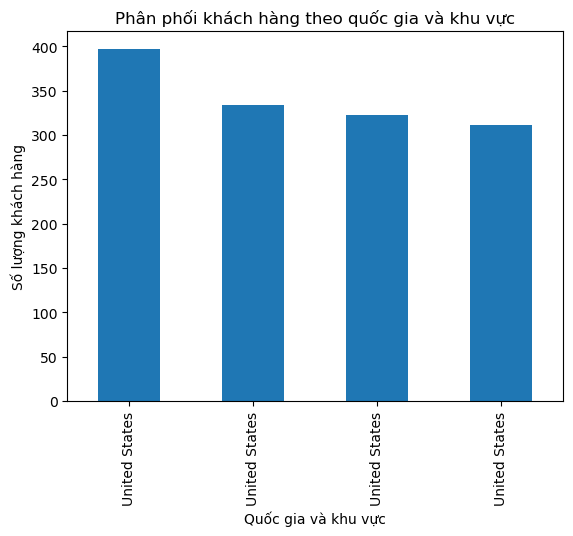

In [149]:
# Phân phối khách hàng theo quốc gia và khu vực
customer_distribution = customer_df.groupBy("country", "region").count().orderBy("count", ascending=False)

# Hiển thị kết quả
customer_distribution.show()

# Visualization
customer_distribution_pd = customer_distribution.toPandas()
plt.figure(figsize=(12,6))
customer_distribution_pd.plot(kind='bar', x='country', y='count', legend=None)
plt.title('Phân phối khách hàng theo quốc gia và khu vực')
plt.ylabel('Số lượng khách hàng')
plt.xlabel('Quốc gia và khu vực')
plt.show()

+----------+-----+
|order_date|count|
+----------+-----+
|2015-01-01|    7|
|2015-01-02|   12|
|2015-01-03|   14|
|2015-01-04|    6|
|2015-01-05|   10|
|2015-01-06|   12|
|2015-01-07|   11|
|2015-01-08|    4|
|2015-01-09|   10|
|2015-01-10|    8|
|2015-01-11|    3|
|2015-01-12|   12|
|2015-01-13|    6|
|2015-01-14|    7|
|2015-01-15|    9|
|2015-01-16|   10|
|2015-01-17|   15|
|2015-01-18|    2|
|2015-01-19|    3|
|2015-01-20|    6|
+----------+-----+
only showing top 20 rows



<Figure size 1000x600 with 0 Axes>

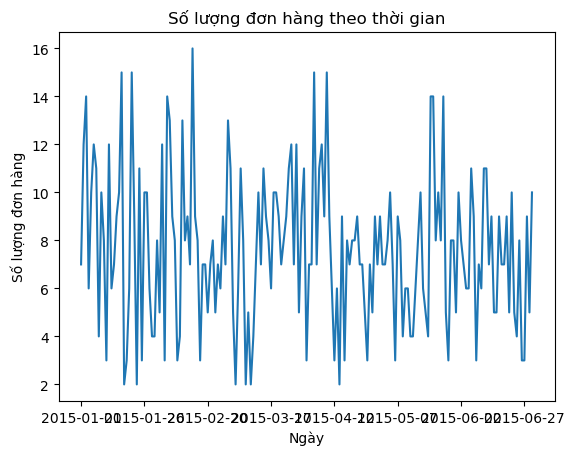

In [151]:
# Số lượng đơn hàng theo thời gian
order_count_by_date = order.groupBy(date_format("order_date", "yyyy-MM-dd").alias("order_date")).count().orderBy("order_date")

# Hiển thị kết quả
order_count_by_date.show()

# Visualization
order_count_by_date_pd = order_count_by_date.toPandas()
plt.figure(figsize=(10,6))
order_count_by_date_pd.plot(kind='line', x='order_date', y='count', legend=None)
plt.title('Số lượng đơn hàng theo thời gian')
plt.ylabel('Số lượng đơn hàng')
plt.xlabel('Ngày')
plt.show()

+---------------+--------------------+-----+
|       category|        sub_category|count|
+---------------+--------------------+-----+
|Office Supplies|               Paper|  284|
|Office Supplies|Binders and Binde...|  200|
|     Technology|Telephones and Co...|  194|
|      Furniture|  Office Furnishings|  185|
|     Technology|Computer Peripherals|  174|
|Office Supplies| Pens & Art Supplies|  161|
|Office Supplies|Storage & Organiz...|  130|
|Office Supplies|          Appliances|  100|
|     Technology|     Office Machines|   95|
|      Furniture|  Chairs & Chairmats|   92|
|      Furniture|              Tables|   80|
|Office Supplies|              Labels|   71|
|Office Supplies|           Envelopes|   55|
|      Furniture|           Bookcases|   43|
|Office Supplies|Scissors, Rulers ...|   36|
|Office Supplies|        Rubber Bands|   34|
|     Technology|     Copiers and Fax|   18|
+---------------+--------------------+-----+



<Figure size 1200x600 with 0 Axes>

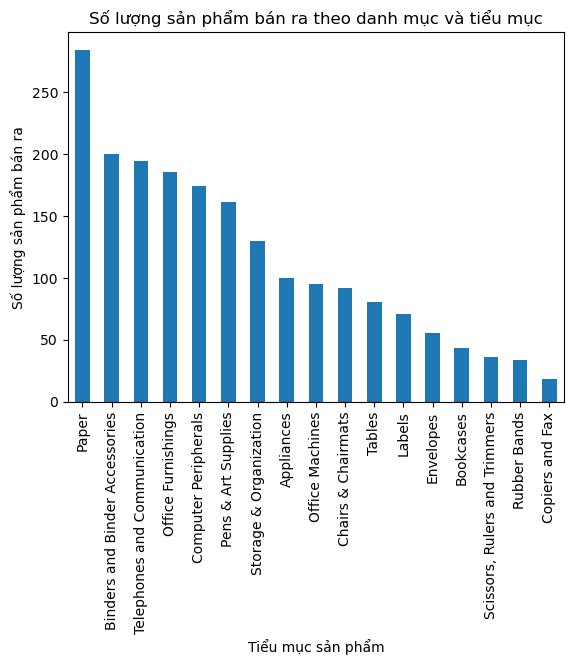

In [157]:
# Số lượng sản phẩm bán ra theo danh mục và tiểu mục
product_sales_by_category = product.groupBy("category", "sub_category").count().orderBy("count", ascending=False)

# Hiển thị kết quả
product_sales_by_category.show()

# Visualization
product_sales_by_category_pd = product_sales_by_category.toPandas()
plt.figure(figsize=(12,6))
product_sales_by_category_pd.plot(kind='bar', x='sub_category', y='count', legend=None)
plt.title('Số lượng sản phẩm bán ra theo danh mục và tiểu mục')
plt.ylabel('Số lượng sản phẩm bán ra')
plt.xlabel('Tiểu mục sản phẩm')
plt.show()

# Close spark session and share jupyter

In [14]:
# Điều chỉnh lại MINIO_ACCESS/SECRET_KEY trước khi share

In [159]:
spark.stop()